In [4]:
import torch
import argparse
import matplotlib.pyplot as plt
import numpy as np

from load_model import load_model
from bayes_radd import mc_marginal  # assume these are defined in bayesRADD
import data

MODEL_PATH   = "JingyangOu/radd-t-dce"
SEQ_LEN      = 1024
BATCH_SIZE   = 16
MAX_BATCHES  = 1
K_CALIB      = 8
K_OOD        = 8
N_BINS       = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, noise = load_model(MODEL_PATH, device)
model.eval()

def build_loader():
    args = argparse.Namespace(
        cache_dir="data", batch_size=BATCH_SIZE,
        length=SEQ_LEN, valid_dataset="wikitext2", ngpus=1
    )
    return data.get_valid_dataloaders(args, distributed=False)

In [6]:
import math
from bayes_radd import baseline_ppl

def compute_ppl_k1(model, noise, device, dataloader, *,
                   max_batches=None, sequence_length=1024):
    """
    Compute the K=1 perplexity *without* Jensen slack:
    uses the analytic DCE loss (baseline_ppl) rather than MC.
    """
    # baseline_ppl returns exp( avg NLL ) over sequences of length `sequence_length`
    return baseline_ppl(
        model, noise, device, dataloader,
        max_batches=max_batches,
        sequence_length=sequence_length
    )

if __name__ == "__main__":
    loader = build_loader()   # your existing dataloader fn
    ppl1 = compute_ppl_k1(
        model, noise, device, loader,
        max_batches=MAX_BATCHES,
        sequence_length=SEQ_LEN
    )
    print(f"K = 1 → analytic PPL (no Jensen slack) = {ppl1:.2f}")


Baseline PPL:   0%|          | 0/1 [00:00<?, ?it/s]

K = 1 → analytic PPL (no Jensen slack) = 33.36


In [2]:
# 1) grab a single sequence
loader   = build_loader()
batch    = next(iter(loader))
x_batch  = batch["input_ids"].to(device)   # [B,T]
x_single = x_batch[0:1]                    # [1,T]

# 2) run your MC marginal with K=1 (single pass) so we see the raw-conf behavior
K = 16
mc_p, _ = mc_marginal(model, noise, x_single, K)  # returns [1,T,V] marginals

# 3) inspect the top‐prob (“confidence”) for the first few tokens
probs, preds = mc_p.max(dim=-1)            # [1,T] each
print("True tokens   :", x_single[0, :20].tolist())
print("Predictions   :", preds[0, :20].tolist())
print("Confidences   :", probs[0, :20].tolist())

# 4) you can also print the unique confidences:
#print("Unique confidences:", torch.unique(probs).tolist())

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/jupyter/RADD/model/transformer.py:155: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=self.dtype):
/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/home/jupyter/RADD/model/transformer.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/jupyter/RADD/model/transformer.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  w

True tokens   : [11882, 287, 2932, 3648, 13, 198, 50256, 21877, 282, 5983, 511, 1182, 12, 1462, 12, 2256, 2242, 784, 1367, 13]
Predictions   : [11882, 287, 2932, 3648, 13, 198, 198, 21877, 282, 5983, 511, 1182, 12, 1462, 12, 2256, 2242, 784, 1367, 13]
Confidences   : [0.36353302001953125, 0.30621713399887085, 0.14242279529571533, 0.22067244350910187, 0.2401682734489441, 0.25424087047576904, 0.3038770258426666, 0.3048613369464874, 0.5229161977767944, 0.2554866671562195, 0.12728537619113922, 0.37066978216171265, 0.5670301914215088, 0.4946891665458679, 0.5667969584465027, 0.3720689117908478, 0.08022642880678177, 0.30329465866088867, 0.048490699380636215, 0.49715039134025574]


In [3]:
sum((x_single == preds)[0].tolist()) / len(x_single[0])

0.9482421875

K = 1  | 0.8887
K = 4  | 0.9063
K = 8  | 0.9213
K = 16 | 0.9348
K = 32 | 0.9453

Ent→Err K=8:   0%|          | 0/1 [00:00<?, ?it/s]

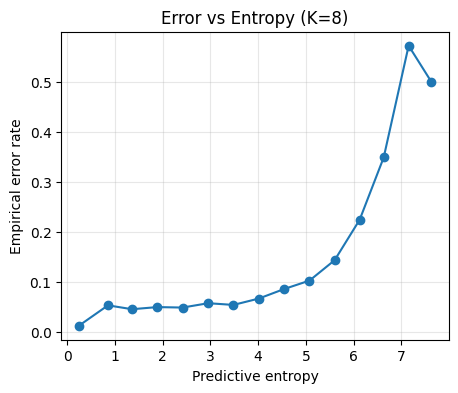

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from bayes_radd import mc_marginal

@torch.no_grad()
def entropy_error_curve(model, noise, device, dataloader, K, n_bins=20, max_batches=None):
    all_H   = []
    all_err = []

    length = min(max_batches, len(dataloader)) if max_batches else len(dataloader)
    for i, batch in enumerate(tqdm(dataloader, total=length, desc=f"Ent→Err K={K}")):
        if max_batches and i >= max_batches:
            break

        x = batch["input_ids"].to(device)    # [B,T]
        B, T = x.shape

        mc_p, _  = mc_marginal(model, noise, x, K)  # [B,T,V']
        pred     = mc_p.argmax(dim=-1)              # [B,T]
        err      = (pred != x).float()              # [B,T]

        # compute per-token entropy
        H = -(mc_p * mc_p.clamp(min=1e-12).log()).sum(dim=-1)  # [B,T]

        all_H.append(H.view(-1).cpu().numpy())
        all_err.append(err.view(-1).cpu().numpy())

    H   = np.concatenate(all_H)
    err = np.concatenate(all_err)
    N   = H.shape[0]

    bins = np.linspace(H.min(), H.max(), n_bins+1)
    centers = 0.5*(bins[:-1] + bins[1:])
    err_rate = np.zeros(n_bins)
    avg_H    = np.zeros(n_bins)
    counts   = np.zeros(n_bins)

    for b in range(n_bins):
        m = (H >= bins[b]) & (H < bins[b+1])
        counts[b] = m.sum()
        if counts[b]>0:
            err_rate[b] = err[m].mean()
            avg_H[b]    = H[m].mean()

    return centers, avg_H, err_rate, counts

# ——— in your notebook ———
K = 8
centers, avg_H, err_rate, counts = entropy_error_curve(
    model, noise, device, build_loader(), K, n_bins=15, max_batches=MAX_BATCHES
)

plt.figure(figsize=(5,4))
plt.plot(avg_H, err_rate, marker='o')
plt.xlabel("Predictive entropy")
plt.ylabel("Empirical error rate")
plt.title(f"Error vs Entropy (K={K})")
plt.grid(True, alpha=0.3)
plt.show()

Var→Err K=8:   0%|          | 0/1 [00:00<?, ?it/s]

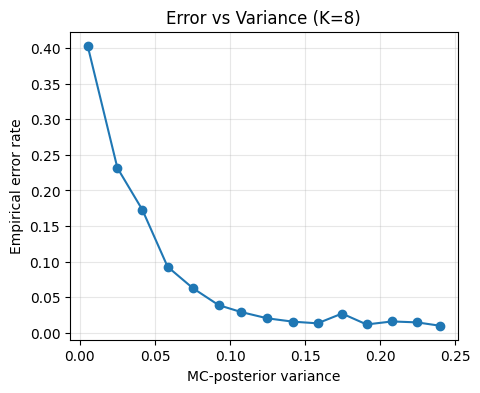

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F
from bayes_radd import mc_marginal, mc_marginal_tokenwise

@torch.no_grad()
def variance_error_curve(model, noise, device, dataloader, K, n_bins=20, max_batches=None):
    """
    Buckets every token by its MC‐posterior variance and computes, for each bin:
      – center of variance-bin
      – empirical error rate (pred != true)
      – average variance
      – token count
    """
    all_var = []
    all_err = []

    length = min(max_batches, len(dataloader)) if max_batches else len(dataloader)
    for i, batch in enumerate(tqdm(dataloader, total=length, desc=f"Var→Err K={K}")):
        if max_batches and i >= max_batches:
            break

        x = batch["input_ids"].to(device)    # [B,T]
        B, T = x.shape

        # 1) get marginal probs & variances
        mc_p, mc_var = mc_marginal(model, noise, x, K)         # [B,T,V']
        pred = mc_p.argmax(dim=-1)                             # [B,T]
        err  = (pred != x).float()                             # [B,T], 1 = wrong

        # 2) get true-token variance
        #    Note: mc_var is full-vocab variance; gather true-token slot
        var_true = mc_var.gather(-1, x.unsqueeze(-1)).squeeze(-1)  # [B,T]

        all_var.append(var_true.view(-1).cpu().numpy())
        all_err.append(err.view(-1).cpu().numpy())

    var = np.concatenate(all_var)
    err = np.concatenate(all_err)
    N   = var.shape[0]

    # build bins in variance-space
    bins = np.linspace(var.min(), var.max(), n_bins+1)
    centers = 0.5*(bins[:-1] + bins[1:])

    err_rate = np.zeros(n_bins)
    avg_var   = np.zeros(n_bins)
    counts    = np.zeros(n_bins)

    for b in range(n_bins):
        m = (var >= bins[b]) & (var < bins[b+1])
        counts[b] = m.sum()
        if counts[b]>0:
            err_rate[b] = err[m].mean()
            avg_var[b]   = var[m].mean()

    return centers, avg_var, err_rate, counts

# ——— how to use in your notebook ———

K = 8
bins, avg_var, err_rate, counts = variance_error_curve(
    model, noise, device, build_loader(), K, n_bins=15, max_batches=MAX_BATCHES
)

plt.figure(figsize=(5,4))
plt.plot(avg_var, err_rate, marker='o', linestyle='-')
plt.xlabel("MC‐posterior variance")
plt.ylabel("Empirical error rate")
plt.title(f"Error vs Variance (K={K})")
plt.grid(True, alpha=0.3)
plt.show()

Calib K=32:   0%|          | 0/1 [00:00<?, ?it/s]

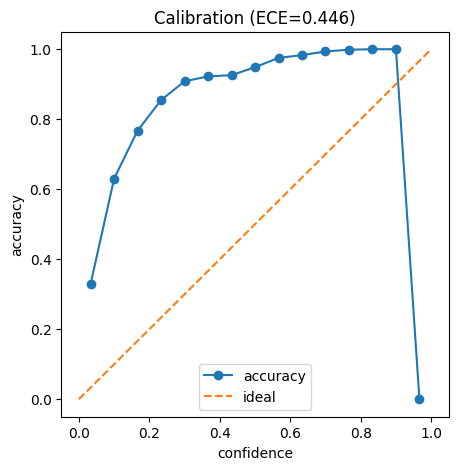

ECE: 0.44614797650910987


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_radd import mc_marginal

# ——— 6) Calibration pass over dataset ————————
@torch.no_grad()
def calibration_curve(model, noise, device, dataloader, K, n_bins=15, max_batches=None):
    all_conf, all_corr = [], []

    length = min(max_batches, len(dataloader)) if max_batches else len(dataloader)
    for i, batch in enumerate(tqdm(dataloader, total=length, desc=f"Calib K={K}")):
        if max_batches and i >= max_batches:
            break
        x = batch["input_ids"].to(device)   # [B,T]
        mc_p, _   = mc_marginal(model, noise, x, K)  # [B,T,V']
        p_conf, p_pred = mc_p.max(dim=-1)            # over V'
        corr = (p_pred == x).float()                 # [B,T]

        all_conf.append(p_conf.view(-1).cpu().numpy())
        all_corr.append(corr.view(-1).cpu().numpy())

    conf = np.concatenate(all_conf)
    corr = np.concatenate(all_corr)
    bins = np.linspace(0,1,n_bins+1)
    centers = (bins[:-1]+bins[1:])/2
    accuracies = np.zeros(n_bins)
    confidences= np.zeros(n_bins)
    counts     = np.zeros(n_bins)
    N = conf.shape[0]

    for b in range(n_bins):
        # include rightmost edge in last bin
        if b == n_bins-1:
            mask = (conf>=bins[b]) & (conf<=bins[b+1])
        else:
            mask = (conf>=bins[b]) & (conf< bins[b+1])
        counts[b] = mask.sum()
        if counts[b]>0:
            accuracies[b]   = corr[mask].mean()
            confidences[b]  = conf[mask].mean()

    ece = np.sum((counts/N) * np.abs(accuracies - confidences))
    return centers, accuracies, confidences, counts, ece

K_CALIB = 8
bins, accs, confs, counts, ece = calibration_curve(
    model, noise, device, build_loader(), K_CALIB, n_bins=15, max_batches=MAX_BATCHES
)

plt.figure(figsize=(5,5))
plt.plot(bins, accs, marker='o', label='accuracy')
plt.plot([0,1],[0,1],'--', label='ideal')
plt.xlabel('confidence')
plt.ylabel('accuracy')
plt.title(f'Calibration (ECE={ece:.3f})')
plt.legend()
plt.show()
print("ECE:", ece)